In [1]:
# !pip install pandas==2.2.0 mioflow

# Use MIOFlow to infer trajectories on PHATE space

Prerequisites:
- You have preprocessed your data and saved a mioflow DataFrame [notebook: 3-time-pseudotime]: 
    - rows are cells
    - columns are embeddings dimensions
    - "samples" are the discrete time labels


In this notebook, we will:
- Run MIOFlow on our PHATE space to infer trajectories

## 1. Importing MIOFlow and defining data paths

In [3]:
import MIOFlow

ModuleNotFoundError: No module named 'MIOFlow'

In [2]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen

from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


adata = sc.read_h5ad('/Users/joaofelipe/Yale/Omics Toolbox/4_Code/omics_toolbox/workshops/cancer_plasticity/mioflow/data.h5ad')
# Enable autoreload for notebook development
%load_ext autoreload
%autoreload 2


ModuleNotFoundError: No module named 'MIOFlow'

## 1. Retrieve the data and embedding normalization
First we retrieve the data.

Then, we will normalize the embeddings as a standard procedure to enable our network to learn better.

**Attention:** It is important to save the _std_ and _mean_ values. 

It is important to save the _std_ and _mean_ values because when decoding back using the `DimChanger`, we need to ensure that the outputs follow the distributions of the initial embeddings.

In [ ]:
adata.obs

AttributeError: module 'pandas._libs.lib' has no attribute 'is_np_dtype'

AttributeError: module 'pandas._libs.lib' has no attribute 'is_np_dtype'

In [ ]:
# Create a numerical bin for each unique value
adata.obs['discrete_time'], _ = pd.factorize(adata.obs['day'])

#Now lets create the data structure that mioflows works on top
mioflow_df = pd.DataFrame(adata.obsm['X_phate'], columns=[f'd{i}' for i in range(1, adata.obsm['X_phate'].shape[1]+1)])

# Add the time labels to the dataframe as a column called 'samples' (this is expected by MIOFlow)
mioflow_df['samples'] = adata.obs['discrete_time'].values
mioflow_df

,d1,d2,samples
0,0.036356,-0.005683,0
1,0.039413,0.000519,0
2,0.034858,-0.003345,0
3,0.030872,-0.004870,0
4,0.034578,-0.002362,0
...,...,...,...
16980,0.004354,0.017672,4
16981,-0.007092,0.008804,4
16982,-0.012404,0.003051,4
16983,-0.012093,0.009553,4


In [ ]:
# Get embedding columns dynamically
embed_cols = [col for col in mioflow_df.columns if col.startswith('d') and col[1:].isdigit()] # Retrieve the columns that start with a d
embedding = mioflow_df[embed_cols].values
embedding

array([[ 0.03635562, -0.00568341],
       [ 0.0394135 ,  0.0005191 ],
       [ 0.03485788, -0.00334511],
       ...,
       [-0.01240443,  0.00305071],
       [-0.01209324,  0.00955291],
       [-0.0103405 ,  0.01165974]])

### Normalizing the data

In [ ]:
# Normalize across all dimensions properly
mean_vals = np.mean(embedding, axis=0)
std_vals = np.std(embedding, axis=0)
std_vals = np.where(std_vals == 0, 1, std_vals)  # Prevent division by zero
normalized = (embedding - mean_vals) / std_vals
# Normalized that is going to be used to train the network
normalized

array([[ 2.16492859, -0.49814357],
       [ 2.3320683 ,  0.17329064],
       [ 2.08306395, -0.24501768],
       ...,
       [-0.50023261,  0.44734295],
       [-0.48322344,  1.15121894],
       [-0.38742085,  1.37928859]])

In [ ]:
# We create the dataframe with the normalized data and the samples
df = pd.DataFrame(normalized, columns=[f'd{i+1}' for i in range(normalized.shape[1])])
df['samples'] = mioflow_df['samples']
df.head(1)

,d1,d2,samples
0,2.164929,-0.498144,0


In [ ]:
# Retrieve the number of samples that are in the less representative class.
min_count = df['samples'].value_counts().min()

### [Optional] We can resample our dataset to take an equal number of samples across the time_labels.

Only uncomment the following lines if you want to resample the dataset!

In [ ]:
# # Retrieve the number of samples that are in the less representative class.
# min_count = df['samples'].value_counts().min()
# # Subsample the dataset to keep the same number of samples across all possible samples
# df = df.groupby('samples').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

### Let's visualize what will be our input data using PHATE

If your data looks right, and we can see a path for the trajectories to follow, we can move on to training the MIOFlow algorithm

<Axes: xlabel='d1', ylabel='d2'>

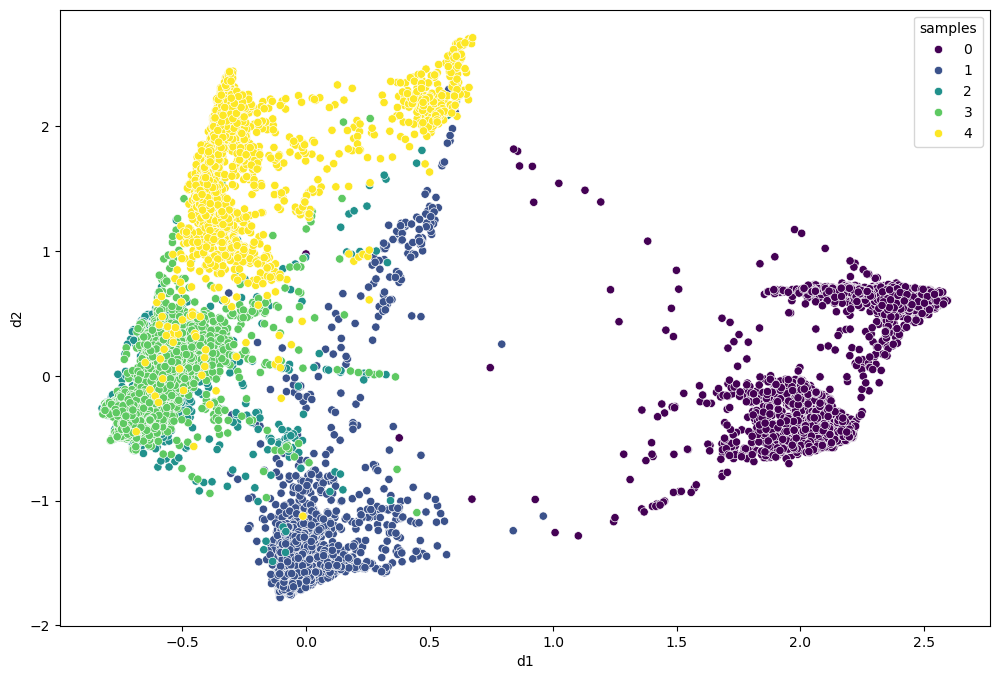

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis')

# Training the MIOFlow Model

A lot of this initial cells will be just setting up configurations to run the MIOFlow algorithm.

In [ ]:
# Import torch library and verify if GPUs are available to be used.
import time
import torch
set_seeds(0)
use_cuda = torch.cuda.is_available()

In [ ]:
from MIOFlow.mioflow import MIOFlow

ModuleNotFoundError: No module named 'MIOFlow.mioflow'

In [ ]:
# =============================================================================
# MIOFlow Training Configuration
# =============================================================================

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================
MODEL_CONFIG = {
    'layers': [16, 32, 16],           # Neural network architecture
    'activation': 'CELU',             # Activation function
    'scales': None,                   # SDE scales (None for default)
    'use_cuda': use_cuda,             # GPU usage
}

# =============================================================================
# TRAINING STRUCTURE CONFIGURATION
# =============================================================================
TRAINING_STRUCTURE = {
    'n_local_epochs': 40,             # Local training epochs (phase 1)
    'n_epochs': 40,                   # Global training epochs (main phase)
    'n_post_local_epochs': 0,         # Post-local training epochs (phase 3)
}

# =============================================================================
# OPTIMIZATION CONFIGURATION
# =============================================================================
OPTIMIZATION_CONFIG = {
    'criterion_type': 'ot',           # Loss criterion type ('ot' = optimal transport)
    'use_density_loss': True,         # Enable density loss (KNN-based)
    'lambda_density': 20,             # Weight for density loss
}

# =============================================================================
# DATA CONFIGURATION
# =============================================================================
DATA_CONFIG = {
    'hold_one_out': False,            # Holdout one timepoint for validation
    'sample_size': 100,               # Batch size (will be min(min_count, value))
    'reverse_schema': True,           # Use reverse trajectories for training
    'reverse_n': 2,                   # Number of reverse trajectories
}

# =============================================================================
# ADVANCED FEATURES (typically not used for single-cell data)
# =============================================================================
ADVANCED_CONFIG = {
    'autoencoder': None,              # GeodesicAutoencoder (None = disabled)
    'use_emb': False,                 # Use embeddings
    'use_gae': False,                 # Use Geodesic AutoEncoder
}

# =============================================================================
# VISUALIZATION AND OUTPUT
# =============================================================================
OUTPUT_CONFIG = {
    'exp_dir': '.',                   # Experiment directory
    'plot_every': 5,                  # Plot frequency during training
    'n_points': 100,                  # Number of points for visualization
    'n_trajectories': 100,            # Number of trajectories for visualization
    'n_bins': 100,                    # Number of bins for discretization
}

# =============================================================================
# INITIALIZE MIOFLOW WITH CONFIG DICTIONARIES
# =============================================================================

# Method 1: Using dictionary unpacking (recommended)
mioflow = MIOFlow(
    adata,
    df=df,
    obsm_key="X_phate",
    debug_level='info',
    
    # Unpack all configurations
    **TRAINING_STRUCTURE,
    **OPTIMIZATION_CONFIG,
    **DATA_CONFIG,
    **ADVANCED_CONFIG,
    **OUTPUT_CONFIG,
    
    # Additional MIOFlow-specific parameters that aren't in your configs
    # (These will be handled by the model creation logic within MIOFlow)
    model_config=MODEL_CONFIG  # Pass the model config separately
)

# Fit the model with the configurations
mioflow_operator = mioflow.fit()


2025-08-11 22:11:23,167 - MIOFlow - INFO - MIOFlow initialized with 16985 cells and 21465 genes
2025-08-11 22:11:23,167 - MIOFlow - INFO - Output directory: .
2025-08-11 22:11:23,168 - MIOFlow - INFO - Starting MIOFlow fitting
2025-08-11 22:11:24,501 - MIOFlow - INFO - Training with structure: {'n_local_epochs': 40, 'n_epochs': 40, 'n_post_local_epochs': 0}
2025-08-11 22:11:24,502 - MIOFlow - INFO - Using CUDA: False


             d1        d2  samples
0      2.164929 -0.498144        0
1      2.332068  0.173291        0
2      2.083064 -0.245018        0
3      1.865215 -0.410061        0
4      2.067753 -0.138552        0
...         ...       ...      ...
16980  0.415784  2.030095        4
16981 -0.209887  1.070130        4
16982 -0.500233  0.447343        4
16983 -0.483223  1.151219        4
16984 -0.387421  1.379289        4

[16985 rows x 3 columns]


Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

2025-08-11 22:11:25,627 - MIOFlow - INFO - Generating points
2025-08-11 22:11:25,637 - MIOFlow - INFO - Generating trajectories
/vast/palmer/pi/krishnaswamy_smita/jcr222/github_projects/MIOFlow/MIOFlow/plots.py:216: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


2025-08-11 22:11:30,883 - MIOFlow - INFO - Generating points
2025-08-11 22:11:30,888 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:11:36,729 - MIOFlow - INFO - Generating points
2025-08-11 22:11:36,735 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:11:42,769 - MIOFlow - INFO - Generating points
2025-08-11 22:11:42,775 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:11:48,385 - MIOFlow - INFO - Generating points
2025-08-11 22:11:48,390 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:11:53,921 - MIOFlow - INFO - Generating points
2025-08-11 22:11:53,926 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:11:59,386 - MIOFlow - INFO - Generating points
2025-08-11 22:11:59,391 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:12:05,168 - MIOFlow - INFO - Generating points
2025-08-11 22:12:05,175 - MIOFlow - INFO - Generating trajectories


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

2025-08-11 22:12:11,172 - MIOFlow - INFO - Generating points
2025-08-11 22:12:11,178 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:12:16,039 - MIOFlow - INFO - Generating points
2025-08-11 22:12:16,044 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:12:20,682 - MIOFlow - INFO - Generating points
2025-08-11 22:12:20,688 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:12:25,152 - MIOFlow - INFO - Generating points
2025-08-11 22:12:25,157 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:12:29,715 - MIOFlow - INFO - Generating points
2025-08-11 22:12:29,724 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:12:34,317 - MIOFlow - INFO - Generating points
2025-08-11 22:12:34,324 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:12:38,938 - MIOFlow - INFO - Generating points
2025-08-11 22:12:38,944 - MIOFlow - INFO - Generating trajectories
2025-08-11 22:12:43,565 - MIOFlow - INFO - Generating points
2025-08-11 22:12:43,571 - MIOFlow - INFO - 

Posttraining Epoch: 0it [00:00, ?it/s]

2025-08-11 22:12:48,266 - MIOFlow - INFO - MIOFlow fitting completed successfully


In [ ]:
mioflow_operator.df

,d1,d2,samples
0,2.164929,-0.498144,0
1,2.332068,0.173291,0
2,2.083064,-0.245018,0
3,1.865215,-0.410061,0
4,2.067753,-0.138552,0
...,...,...,...
16980,0.415784,2.030095,4
16981,-0.209887,1.070130,4
16982,-0.500233,0.447343,4
16983,-0.483223,1.151219,4


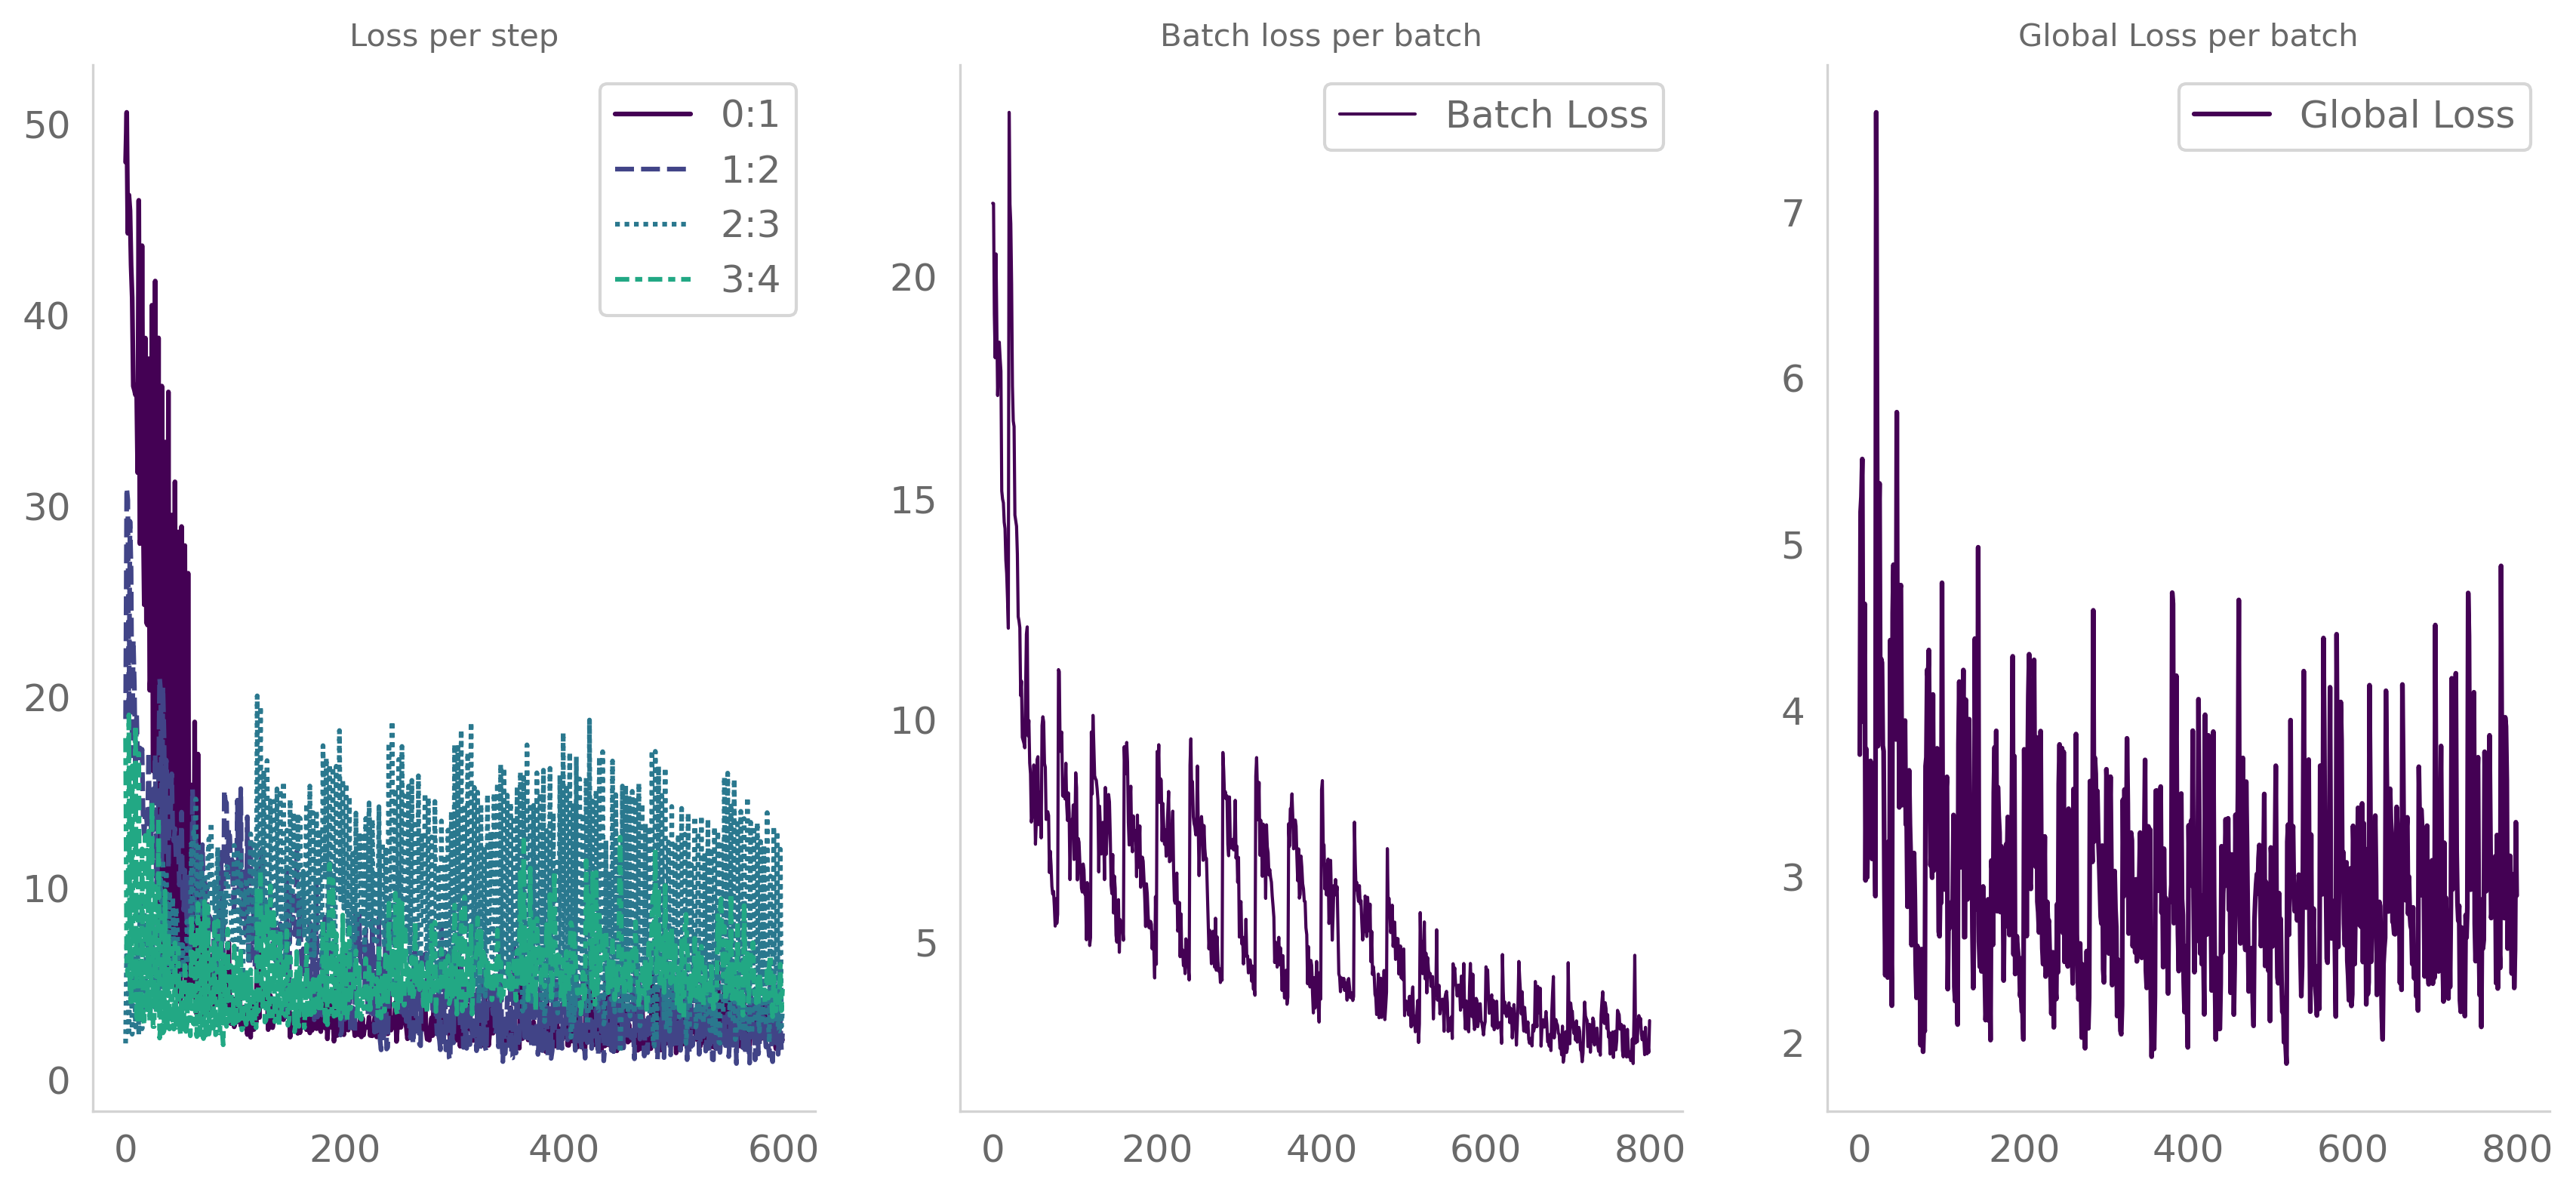

In [ ]:
plot_losses(
    mioflow_operator.local_losses, 
    mioflow_operator.batch_losses, 
    mioflow_operator.globe_losses, 
    save=True, 
    path='.', 
    file='losses.png'
)

In [ ]:
generated, trajectoriespts = generate_plot_data(
    mioflow_operator.model, 
    mioflow_operator.df, 
    n_points=100, 
    n_trajectories=100, 
    n_bins=100, 
    use_cuda=use_cuda, 
    samples_key='samples', 
    logger=None,
    autoencoder=None, 
    recon=None
)

## Visualizing the MIOFlow Outputs and saving

In [ ]:
trajectoriespts = trajectoriespts * std_vals + mean_vals
generated = generated * std_vals + mean_vals
true_data = df[[f'd{i}' for i in range(1, len(df.columns))]] * std_vals + mean_vals

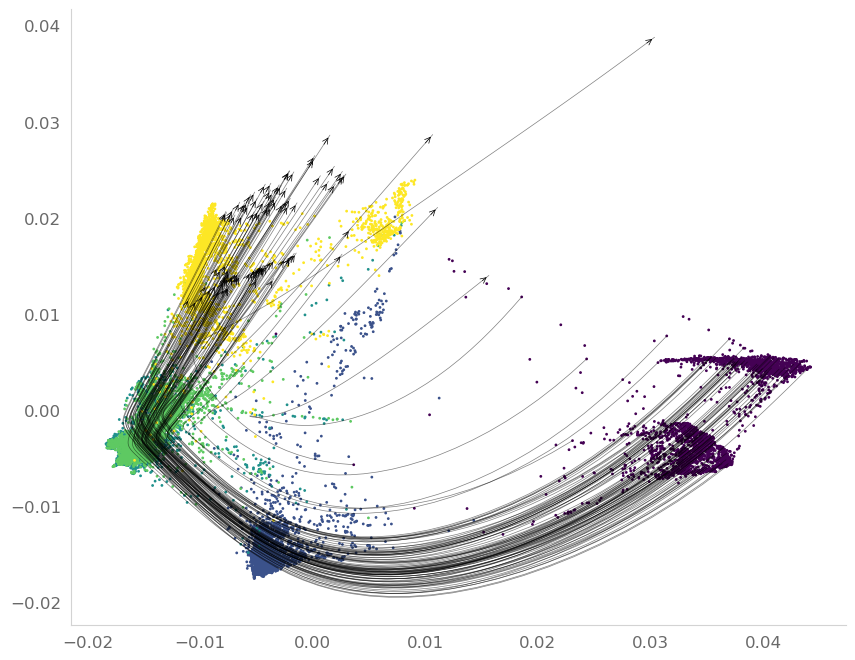

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(true_data.values[:, 0], true_data.values[:, 1], c=df['samples'].values, cmap='viridis', s=1)
for i,traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color='Black', lw=.5, mutation_scale=10))